# ECON 470 Homework 3
### Ellen Wu

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
from statsmodels.formula.api import ols
from causalinference import CausalModel
from IPython.display import Markdown, display
from linearmodels.iv import IV2SLS
import warnings
warnings.simplefilter('ignore')

In [5]:
# Load data
df = pd.read_csv("/Users/ellenwu/homework3/data/output/Taxburden_data.csv")
df['tax_change'] = df.groupby('state')['tax_state'].diff().notna()

1. Present a bar graph showing the proportion of states with a change in their cigarette tax in each year from 1970 to 1985.

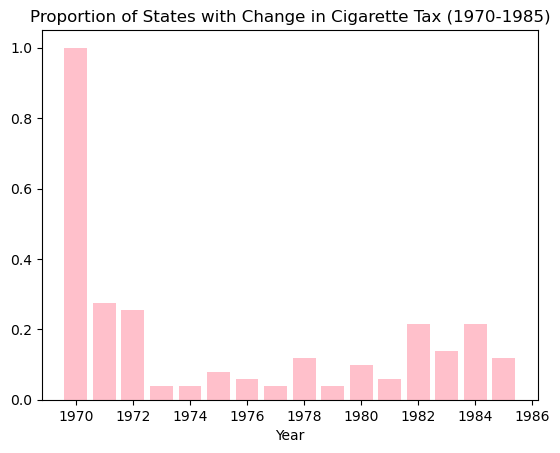

In [6]:
#finding prop of states that had change in tax from 1970-1986
df = df.sort_values(by=['state', 'Year'])
df = df[(df['Year']>=1970) & (df['Year']<=1985)]
df['tax_change'] = df.groupby('state')['tax_state'].diff().ne(0).astype(int)
tax_change = df.groupby('Year')['tax_change'].mean()


plt.bar(tax_change.index, tax_change.values, color='pink')
plt.title('Proportion of States with Change in Cigarette Tax (1970-1985)')
plt.xlabel('Year')
plt.show()

2. Plot on a single graph the average tax (in 2012 dollars) on cigarettes and the average price of a pack of cigarettes from 1970 to 2018.

In [7]:
df = pd.read_csv("/Users/ellenwu/homework3/data/output/Taxburden_data.csv")
 
# Filter for years 1970 to 2018
df = df[(df['Year'] >= 1970) & (df['Year'] <= 2018)]

# Use CPI to adjust to 2012 dollars
# Assuming 2012 CPI = 230 (You should check the exact CPI value for 2012 from your dataset if available)
df['cost_per_pack_2012'] = df['cost_per_pack'] * (230 / df['index'])
df['tax_state_2012'] = df['tax_state'] * (230 / df['index'])

# Group by year and compute average across all states
annual_avg = df.groupby('Year').agg({
    'cost_per_pack_2012': 'mean',
    'tax_state_2012': 'mean'
}).reset_index()

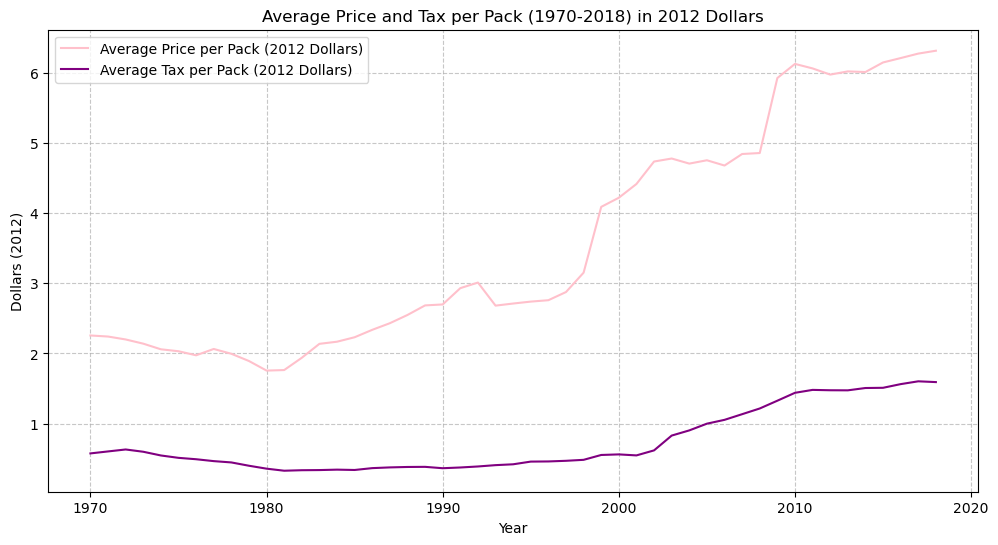

In [8]:
# Plot
plt.figure(figsize=(12, 6))

plt.plot(annual_avg['Year'], annual_avg['cost_per_pack_2012'], label='Average Price per Pack (2012 Dollars)', color='pink')
plt.plot(annual_avg['Year'], annual_avg['tax_state_2012'], label='Average Tax per Pack (2012 Dollars)', color='purple')

plt.title('Average Price and Tax per Pack (1970-2018) in 2012 Dollars')
plt.xlabel('Year')
plt.ylabel('Dollars (2012)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

3. Identify the 5 states with the highest increases in cigarette prices (in dollars) over the time period. Plot the average number of packs sold per capita for those states from 1970 to 2018.

In [9]:
# Identify price change over time per state
price_change = df.groupby('state')['cost_per_pack'].agg(['first', 'last']).reset_index()
price_change['price_increase'] = price_change['last'] - price_change['first']

# Get top 5 states with highest price increases
top5_states = price_change.sort_values('price_increase', ascending=False).head(5)['state']

# Filter dataset to only those states
top5_df = df[df['state'].isin(top5_states)]

# Group by year and state to calculate average packs sold per capita
packs_per_capita = top5_df.groupby(['Year', 'state'])['sales_per_capita'].mean().reset_index()

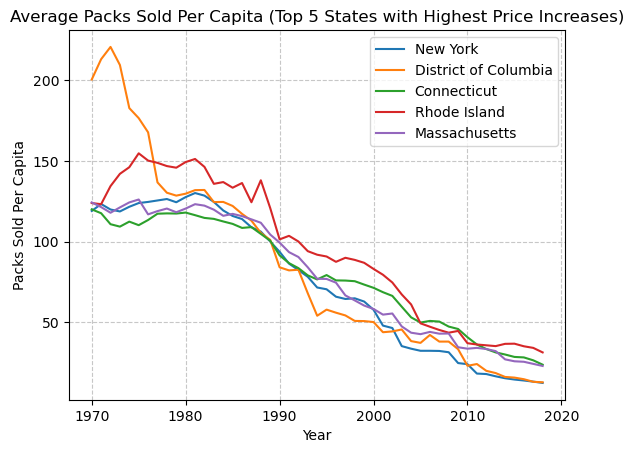

In [10]:
for state in top5_states:
    state_data = packs_per_capita[packs_per_capita['state'] == state]
    plt.plot(state_data['Year'], state_data['sales_per_capita'], label=state)

plt.title('Average Packs Sold Per Capita (Top 5 States with Highest Price Increases)')
plt.xlabel('Year')
plt.ylabel('Packs Sold Per Capita')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

4. Identify the 5 states with the lowest increases in cigarette prices over the time period. Plot the average number of packs sold per capita for those states from 1970 to 2018.

In [11]:
df = pd.read_csv("/Users/ellenwu/homework3/data/output/Taxburden_data.csv")

# Filter for years 1970-2018
df = df[(df['Year'] >= 1970) & (df['Year'] <= 2018)]

# Compute the price difference between 1970 and 2018
price_change = df.groupby('state')['price_cpi'].agg(['first', 'last'])
price_change['price_increase'] = price_change['last'] - price_change['first']

# Identify the 5 states with the lowest price increase
bottom_5_states = price_change.nsmallest(5, 'price_increase').index.tolist()
print("Bottom 5 states with lowest price increase:", bottom_5_states)

# Filter the dataset for these states only
df = df[df['state'].isin(bottom_5_states)]

# Compute the average packs sold per capita for these states each year
avg_sales_per_year = df.groupby(['Year', 'state'])['sales_per_capita'].mean().unstack

Bottom 5 states with lowest price increase: ['Missouri', 'Tennessee', 'North Dakota', 'Alabama', 'Georgia']


In [12]:
# Regenerate the correct DataFrame
avg_sales_per_year = df.groupby(['Year', 'state'])['sales_per_capita'].mean().unstack()

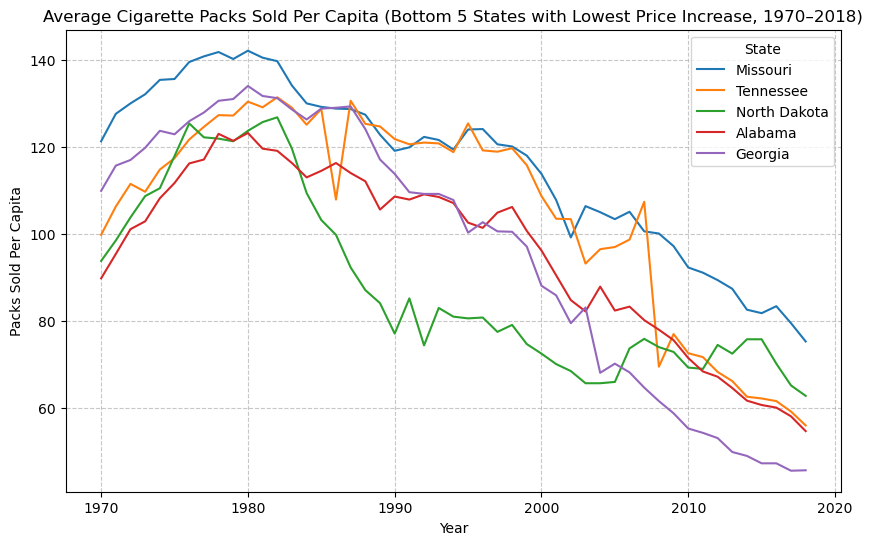

In [13]:
plt.figure(figsize=(10, 6))

for state in bottom_5_states:
    if state in avg_sales_per_year.columns:
        plt.plot(avg_sales_per_year.index, avg_sales_per_year[state], label=state)
    else:
        print(f"Warning: {state} not found in avg_sales_per_year columns")

# Graph formatting
plt.xlabel('Year')
plt.ylabel('Packs Sold Per Capita')
plt.title('Average Cigarette Packs Sold Per Capita (Bottom 5 States with Lowest Price Increase, 1970–2018)')
plt.legend(title="State")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

5. Compare the trends in sales from the 5 states with the highest price increases to those with the lowest price increases.

In [14]:
df = pd.read_csv("/Users/ellenwu/homework3/data/output/Taxburden_data.csv")

# Filter for years 1970-2018
df = df[(df['Year'] >= 1970) & (df['Year'] <= 2018)]

# Compute the first and last cigarette price for each state
price_change = df.groupby("state")["price_cpi"].agg(["first", "last"])
price_change["price_increase"] = price_change["last"] - price_change["first"]

# Identify the 5 states with the highest price increase
top_5_states = price_change.nlargest(5, "price_increase").index.tolist()
print("Top 5 states with highest price increase:", top_5_states)

# Identify the 5 states with the lowest price increase
bottom_5_states = price_change.nsmallest(5, "price_increase").index.tolist()
print("Bottom 5 states with lowest price increase:", bottom_5_states)

# Filter the dataset for these states only
df_top = df[df["state"].isin(top_5_states)]
df_bottom = df[df["state"].isin(bottom_5_states)]

# Compute the average packs sold per capita for each group
avg_sales_top = df_top.groupby('Year')['sales_per_capita'].mean()
avg_sales_bottom = df_bottom.groupby('Year')['sales_per_capita'].mean()

Top 5 states with highest price increase: ['District of Columbia', 'New York', 'Rhode Island', 'Hawaii', 'Massachusetts']
Bottom 5 states with lowest price increase: ['Missouri', 'Tennessee', 'North Dakota', 'Alabama', 'Georgia']


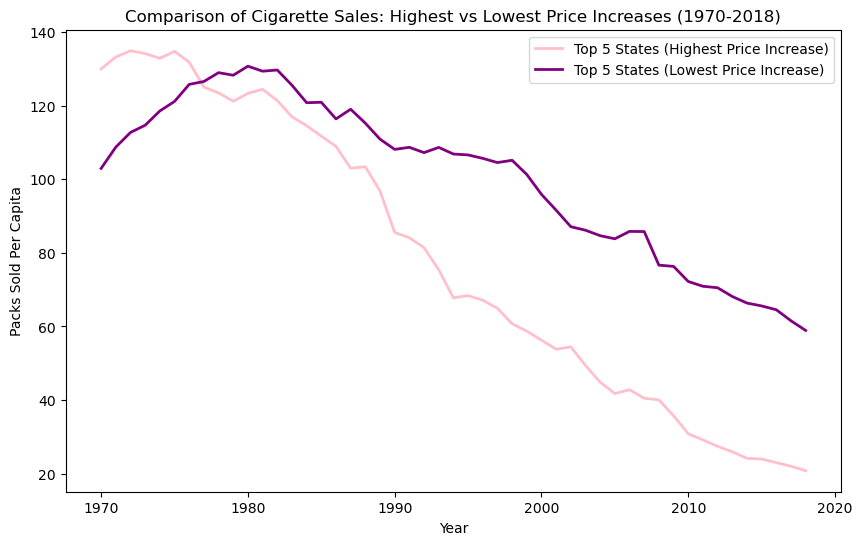

In [15]:
# Group by year and calculate mean sales_per_capita for each group (top 5 and bottom 5)

# Plot the trends for both groups
plt.figure(figsize=(10, 6))
plt.plot(avg_sales_top.index, avg_sales_top, label='Top 5 States (Highest Price Increase)', color='pink', linewidth=2)
plt.plot(avg_sales_bottom.index, avg_sales_bottom, label='Top 5 States (Lowest Price Increase)', color='purple', linewidth=2)

# Format Graph
plt.xlabel('Year')
plt.ylabel('Packs Sold Per Capita')
plt.legend()
plt.title('Comparison of Cigarette Sales: Highest vs Lowest Price Increases (1970-2018)')
plt.show()

The five states with the highest increases in cigarette prices experienced a sharp decline in packs sold per capita from 1970 to 2018, reflecting the impact of higher prices and likely stronger tobacco control policies. In contrast, the five states with the lowest price increases saw higher and more stable cigarette consumption over time, with only a gradual decline. This suggests that states with smaller price hikes, many of which are historically tied to tobacco production, were less aggressive in discouraging smoking through price-based policies.

6. Focusing only on the time period from 1970 to 1990, regress log sales on log prices to estimate the price elasticity of demand over that period. Interpret your results.

In [16]:
df = pd.read_csv("/Users/ellenwu/homework3/data/output/Taxburden_data.csv")

# Filter for years 1970-1990
df = df[(df['Year'] >= 1970) & (df['Year'] <= 1990)]

# Take the natural log of sales_per_capita and price_cpi
df['log_sales'] = np.log(df['sales_per_capita'])
df['log_price'] = np.log(df['price_cpi'])

# Drop any rows with missing values
df = df.dropna(subset=['log_sales', 'log_price'])

# Define dependent (Y) and independent (X) variables
X = sm.add_constant(df['log_price'])
Y = df['log_sales']

# Run and print OLS regression
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     445.1
Date:                Thu, 20 Mar 2025   Prob (F-statistic):           6.98e-83
Time:                        15:49:17   Log-Likelihood:                 263.40
No. Observations:                1071   AIC:                            -522.8
Df Residuals:                    1069   BIC:                            -512.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3854      0.028    193.692      0.0

The estimated price elasticity of demand for cigarettes between 1970 and 1990 is approximately -0.093. This indicates that a 10% increase in cigarette prices is associated with a 0.93% decrease in cigarette sales per capita, suggesting that demand for cigarettes was relatively inelastic during this period — meaning consumers were not very responsive to price changes.

7. Again limiting to 1970 to 1990, regress log sales on log prices using the total (federal and state) cigarette tax (in dollars) as an instrument for log prices. Interpret your results and compare your estimates to those without an instrument. Are they different? If so, why?

In [17]:
df = pd.read_csv("/Users/ellenwu/homework3/data/output/Taxburden_data.csv")

# Filter for years 1970-1990
df = df[(df['Year'] >= 1970) & (df['Year'] <= 1990)]

# Take the natural log of sales, price, and tax
df['log_sales'] = np.log(df['sales_per_capita'])
df['log_price'] = np.log(df['price_cpi'])
df['log_tax'] = np.log(df['tax_dollar'])

# Drop any rows with  missing values
df = df.dropna(subset=['log_sales', 'log_price', 'log_tax'])

# First-Stage Regresson: Predict log(price) using log(tax) 
X_first_stage = sm.add_constant(df['log_tax']) #IV
Y_first_stage = df['log_price'] # Endogenous variable

first_stage_model = sm.OLS(Y_first_stage, X_first_stage).fit()
df['log_price_hat'] = first_stage_model.predict(X_first_stage)

print('First-Stage Regression Results:')
print(first_stage_model.summary())

First-Stage Regression Results:
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     1725.
Date:                Thu, 20 Mar 2025   Prob (F-statistic):          2.80e-225
Time:                        15:49:23   Log-Likelihood:                 1020.7
No. Observations:                1071   AIC:                            -2037.
Df Residuals:                    1069   BIC:                            -2027.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.181

In [18]:
# Second-Stage Regresson: Use predicited log(price) 
X_second_stage = sm.add_constant(df['log_price_hat']) # use predicted price
Y_second_stage = df['log_sales'] # dependent variable

second_stage_model = sm.OLS(Y_second_stage, X_second_stage).fit()

print("\nSecond-Stage (IV) Regression Results:")
print(second_stage_model.summary())

# Extract estimated price elasticity
elasticity_iv = second_stage_model.params["log_price_hat"]
print(f"\nIV-Estimated Price Elasticity of Demand: {elasticity_iv:.3f}")

# Compare IV Estimates to OLS Estimates 
# Re-run the simple OLS regression (from Q6) for direct comparison
X_ols = sm.add_constant(df['log_price'])
ols_model = sm.OLS(Y_second_stage, X_ols).fit()
elasticity_ols = ols_model.params['log_price']

print(f"\nOLS-Estimated Price Elasticity: {elasticity_ols:.3f}")
print(f"Difference between OLS and IV Estimates: {elasticity_ols - elasticity_iv:.3f}")


Second-Stage (IV) Regression Results:
                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     330.3
Date:                Thu, 20 Mar 2025   Prob (F-statistic):           1.56e-64
Time:                        15:49:28   Log-Likelihood:                 221.17
No. Observations:                1071   AIC:                            -438.3
Df Residuals:                    1069   BIC:                            -428.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const  

Based on the results, when using the total cigarette tax as an instrument for log prices, the IV-estimated price elasticity of demand is -0.923, compared to -0.809 from the OLS regression without an instrument. The IV estimate is slightly more negative, suggesting that the OLS approach may have been biased toward a smaller (less negative) elasticity, potentially due to endogeneity in the relationship between price and sales. The first-stage regression confirms that log tax is a strong instrument for log price, as indicated by the high F-statistic (1725) and the significant relationship between log tax and log price (coefficient = 0.3328, p < 0.001). This suggests that IV is addressing potential simultaneity bias, making the IV estimate more reliable in capturing the causal effect of price on cigarette demand.

8. Show the first stage and reduced-form results from the instrument.

In [19]:
df = pd.read_csv("/Users/ellenwu/homework3/data/output/Taxburden_data.csv")

# Filter data for 1970 to 1990
df = df[(df['Year'] >= 1970) & (df['Year'] <= 1990)]

# Take natural log of sales, price, and tax
df["log_sales"] = np.log(df["sales_per_capita"])
df["log_price"] = np.log(df["price_cpi"])
df["log_tax"] = np.log(df["tax_dollar"])

# Drop any rows with missing values
df = df.dropna(subset=["log_sales", "log_price", "log_tax"])

# ------------ First-Stage Regresson: Predict log(price) using log(tax) ------------
X_first_stage = sm.add_constant(df['log_tax']) # instrument
Y_first_stage = df['log_price'] #endogenous variable

first_stage_model = sm.OLS(Y_first_stage, X_first_stage).fit()

print("\n=== First-Stage Regression: Log(Price) ~ Log(Tax) ===")
print(first_stage_model.summary())


=== First-Stage Regression: Log(Price) ~ Log(Tax) ===
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     1725.
Date:                Thu, 20 Mar 2025   Prob (F-statistic):          2.80e-225
Time:                        15:49:35   Log-Likelihood:                 1020.7
No. Observations:                1071   AIC:                            -2037.
Df Residuals:                    1069   BIC:                            -2027.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [20]:
X_reduced_form = sm.add_constant(df['log_tax']) #tax is regressor
Y_reduced_form = df['log_sales'] #dependent variable

reduced_form_model = sm.OLS(Y_reduced_form, X_reduced_form).fit()
print("\n=== Reduced-Form Regression: Log(Sales) ~ Log(Tax) ===")
print(reduced_form_model.summary())


=== Reduced-Form Regression: Log(Sales) ~ Log(Tax) ===
                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     330.3
Date:                Thu, 20 Mar 2025   Prob (F-statistic):           1.56e-64
Time:                        15:49:51   Log-Likelihood:                 221.17
No. Observations:                1071   AIC:                            -438.3
Df Residuals:                    1069   BIC:                            -428.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------


The first-stage regression results show that log(tax) is a strong predictor of log(price), with a coefficient of 0.3328 and an R-squared of 0.617, indicating that taxes explain a significant portion of price variation. The reduced-form regression results reveal a negative relationship between log(tax) and log(sales), with a coefficient of -0.3072, suggesting that higher taxes lead to lower cigarette consumption. Both regressions have highly significant coefficients (p < 0.001), reinforcing that tax is a relevant instrument for price in estimating demand elasticity.

9. Repeat questions 1-3 focusing on the period from 1991 to 2015.

In [21]:
df = pd.read_csv("/Users/ellenwu/homework3_attempt1-/data/output/TaxBurden_Data.csv")
df['tax_change'] = df.groupby('state')['tax_state'].diff().notna()
prop_change = df.groupby('Year')['tax_change'].mean()

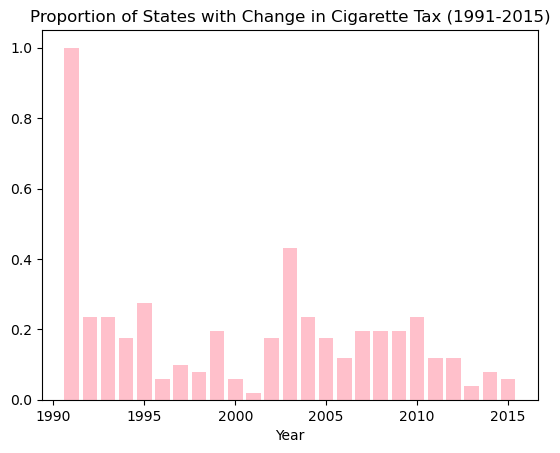

In [22]:
#finding prop of states that had change in tax from 1991-2015
df = df.sort_values(by=['state', 'Year'])
df = df[(df['Year']>=1991) & (df['Year']<=2015)]
df['tax_change'] = df.groupby('state')['tax_state'].diff().ne(0).astype(int)
tax_change = df.groupby('Year')['tax_change'].mean()


plt.bar(tax_change.index, tax_change.values, color='pink')
plt.title('Proportion of States with Change in Cigarette Tax (1991-2015)')
plt.xlabel('Year')
plt.show()

plt.show()

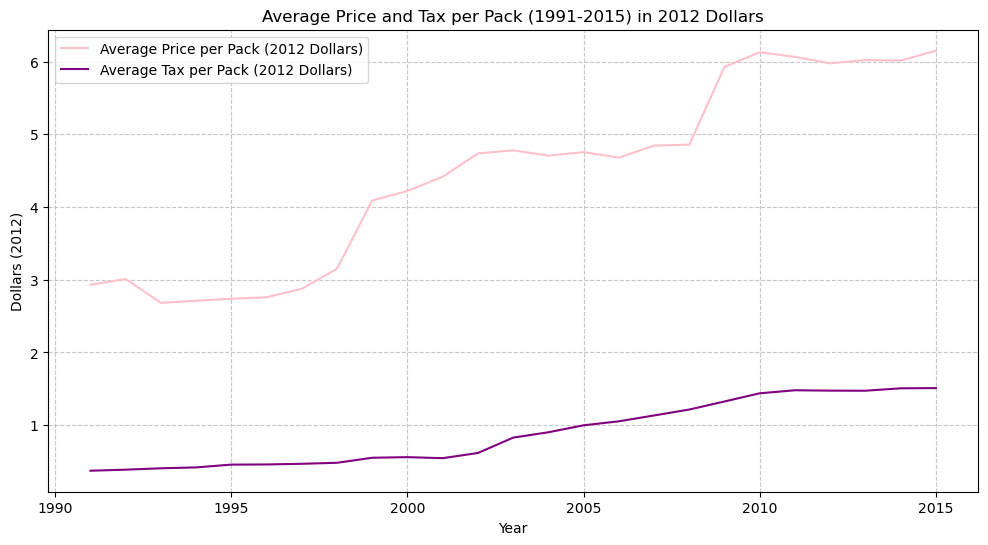

In [23]:
df = df[(df['Year'] >= 1991) & (df['Year'] <= 2015)]

# Use CPI to adjust to 2012 dollars
# Assuming 2012 CPI = 230 (You should check the exact CPI value for 2012 from your dataset if available)
df['cost_per_pack_2012'] = df['cost_per_pack'] * (230 / df['index'])
df['tax_state_2012'] = df['tax_state'] * (230 / df['index'])

# Group by year and compute average across all states
annual_avg = df.groupby('Year').agg({
    'cost_per_pack_2012': 'mean',
    'tax_state_2012': 'mean'
}).reset_index()

# Plot
plt.figure(figsize=(12, 6))

plt.plot(annual_avg['Year'], annual_avg['cost_per_pack_2012'], label='Average Price per Pack (2012 Dollars)', color='pink')
plt.plot(annual_avg['Year'], annual_avg['tax_state_2012'], label='Average Tax per Pack (2012 Dollars)', color='purple')

plt.title('Average Price and Tax per Pack (1991-2015) in 2012 Dollars')
plt.xlabel('Year')
plt.ylabel('Dollars (2012)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

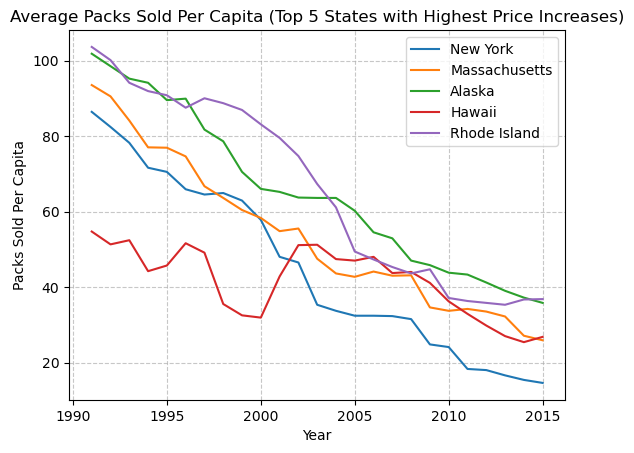

In [24]:
df = df[(df['Year'] >= 1991) & (df['Year'] <= 2015)]

# Identify price change over time per state
price_change = df.groupby('state')['cost_per_pack'].agg(['first', 'last']).reset_index()
price_change['price_increase'] = price_change['last'] - price_change['first']

# Get top 5 states with highest price increases
top5_states = price_change.sort_values('price_increase', ascending=False).head(5)['state']

# Filter dataset to only those states
top5_df = df[df['state'].isin(top5_states)]

# Group by year and state to calculate average packs sold per capita
packs_per_capita = top5_df.groupby(['Year', 'state'])['sales_per_capita'].mean().reset_index()

for state in top5_states:
    state_data = packs_per_capita[packs_per_capita['state'] == state]
    plt.plot(state_data['Year'], state_data['sales_per_capita'], label=state)

plt.title('Average Packs Sold Per Capita (Top 5 States with Highest Price Increases)')
plt.xlabel('Year')
plt.ylabel('Packs Sold Per Capita')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

10. Compare your elasticity estimates from 1970-1990 versus those from 1991-2015. Are they different? If so, why?

In [27]:
df = pd.read_csv("/Users/ellenwu/homework3_attempt1-/data/output/TaxBurden_Data.csv")
# Function to estimate price elasticity of demand for a given period
def estimate_elasticity(df, start_year, end_year):
    df_period = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)].copy()

    df_period["log_sales"] = np.log(df_period["sales_per_capita"])
    df_period["log_price"] = np.log(df_period["price_cpi"])

    df_period = df_period.dropna(subset=["log_sales", "log_price"])

    X = sm.add_constant(df_period["log_price"])
    Y = df_period["log_sales"]

    model = sm.OLS(Y, X).fit()

    elasticity = model.params["log_price"]
    print(f"\n=== Price Elasticity Estimate for {start_year}-{end_year} ===")
    print(model.summary())
    print(f"Estimated Price Elasticity: {elasticity:.3f}")

    return elasticity

# Estimate elasticity for 1970-1990
elasticity_1970_1990 = estimate_elasticity(df, 1970, 1990)

# Estimate elasticity for 1991-2015
elasticity_1991_2015 = estimate_elasticity(df, 1991, 2015)

# Compare the results
print("\n=== Elasticity Comparison ===")
print(f"Elasticity (1970-1990): {elasticity_1970_1990:.3f}")
print(f"Elasticity (1991-2015): {elasticity_1991_2015:.3f}")
print(f"Difference: {elasticity_1970_1990 - elasticity_1991_2015:.3f}")


=== Price Elasticity Estimate for 1970-1990 ===
                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     445.1
Date:                Thu, 20 Mar 2025   Prob (F-statistic):           6.98e-83
Time:                        15:50:55   Log-Likelihood:                 263.40
No. Observations:                1071   AIC:                            -522.8
Df Residuals:                    1069   BIC:                            -512.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con